In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ls

gdrive	sample_data


In [ ]:
%cd /content/gdrive/MyDrive/ENEL645

/content/gdrive/MyDrive/ENEL645


In [1]:
'''

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/gdrive/MyDrive/ENEL645/chest_xray/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
'''

'\n\n# Input data files are available in the read-only "../input/" directory\n# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory\n\nimport os\nfor dirname, _, filenames in os.walk(\'/content/gdrive/MyDrive/ENEL645/chest_xray/\'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n'

In [2]:
dataroot = 'data'
!wget --no-check-certificate -O '/content/chest-xray-pneumonia.zip' 'https://docs.google.com/uc?export=download&id=1-3AcmjSQsTGcWHBcAQKGkjI4Un1I9wGr&confirm=t'
!mkdir -p {dataroot}
!unzip -q -n '/content/chest-xray-pneumonia.zip' -d {dataroot}

'wget' is not recognized as an internal or external command,
operable program or batch file.
'id' is not recognized as an internal or external command,
operable program or batch file.
'confirm' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
import keras
import tensorflow as tf
from keras import backend as K
from keras import metrics
from keras.regularizers import l2
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, InputLayer, Activation
from keras.preprocessing.image import ImageDataGenerator
from keras.metrics import AUC, Accuracy, Precision, SensitivityAtSpecificity
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
from tensorflow.keras.applications.vgg19 import VGG19 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
'''
import tensorflow as tf
from tensorflow.python.keras import backend as K

# adjust values to your needs
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 8} )
sess = tf.compat.v1.Session(config=config) 
K.set_session(sess)
print(sess)
'''

In [5]:
## Set file paths to image files
#project_path = "/content/gdrive/MyDrive/ENEL645/chest_xray/"
project_path="G:/My Drive/datasets/xray-pneumonia/chest_xray/chest_xray/"
train_path = project_path + "train"
val_path = project_path + "val"
test_path = project_path + "test"

In [20]:
model_preprocessing = lambda x: tf.keras.applications.vgg19.preprocess_input(x)

#Custom data augmentation

In [24]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation
class CustomAugmentation(tf.keras.layers.Layer):
    def __init__(self,preprocessing, rotation_factor=0.05, **kwargs):
        super(CustomAugmentation, self).__init__(**kwargs)
        self.rotation_factor = rotation_factor
        self.rotation_layer = RandomRotation(factor=self.rotation_factor, fill_mode='constant',fill_value=0)
        self.preprocessing = preprocessing
    def call(self, inputs, training=True):
        if training:
            # randomly choose whether to apply the rotation or not
            if tf.random.uniform(()) < 0.5:
                return self.preprocessing(self.rotation_layer(inputs, training=training))
        # if not training or not applying the rotation, return the original image
        return self.preprocessing(inputs)




In [25]:
## Set up hyperparameters that will be used later
hyper_dimension = 224
hyper_batch_size = 32
hyper_epochs = 100
hyper_channels = 3
hyper_mode = 'rgb'

## Generate batches of image data (train, validation, and test) with data augmentation
train_datagen = ImageDataGenerator(preprocessing_function=CustomAugmentation(preprocessing=model_preprocessing))
                                # rescale=1.0/255.0, 
                                #    rotation_range=20,
                                #    shear_range = 0.2,
                                #    zoom_range = 0.2, 
                                #    )
val_datagen = ImageDataGenerator(preprocessing_function=model_preprocessing)
                                    #rescale=1.0/255.0) 
test_datagen = ImageDataGenerator(preprocessing_function=model_preprocessing) 


train_generator = train_datagen.flow_from_directory(directory = train_path, 
                                                    target_size = (hyper_dimension, hyper_dimension),
                                                    batch_size = hyper_batch_size, 
                                                    color_mode = hyper_mode,
                                                    class_mode = 'binary', 
                                                    seed = 42)
val_generator = val_datagen.flow_from_directory(directory = val_path, 
                                                 target_size = (hyper_dimension, hyper_dimension),
                                                 batch_size = hyper_batch_size, 
                                                 class_mode = 'binary',
                                                 color_mode = hyper_mode,
                                                 shuffle=False,
                                                 seed = 42)
test_generator = test_datagen.flow_from_directory(directory = test_path, 
                                                 target_size = (hyper_dimension, hyper_dimension),
                                                 batch_size = hyper_batch_size, 
                                                 class_mode = 'binary',
                                                 color_mode = hyper_mode,
                                                 shuffle=False,
                                                 seed = 42)

test_generator.reset()


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [10]:
from collections import Counter

counter = Counter(train_generator.classes)

print(counter[0])
print(counter[1])
class_weights={0:counter[0]/(counter[0]+counter[1]),1:counter[1]/(counter[0]+counter[1])}
print(class_weights)

1341
3875
{0: 0.2570935582822086, 1: 0.7429064417177914}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


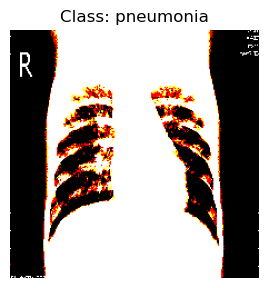

In [26]:
labels = ['normal','pneumonia']
samples = train_generator.__next__()
images = samples[0]
target = samples[1]

plt.figure(figsize = (20 , 20))
for i in range(1):
    plt.subplot(5 , 5, i+1)
    plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
    plt.imshow(images[i])
    plt.title(f"Class: {labels[int(target[i])]}")
    plt.axis('off')


In [9]:
 #Set up the VGG19 model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(hyper_dimension, hyper_dimension, hyper_channels))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom head layers for your specific classification task
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

# Compile the model with an optimizer, loss function, and metrics
model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.0001),  loss='binary_crossentropy',  metrics=[Accuracy()])

In [11]:


filepath= "model_cnn1.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False)
e_s = EarlyStopping(monitor='val_loss', patience=8)



In [12]:
# Train the model
vgg19_model= model.fit(train_generator, 
          steps_per_epoch = len(train_generator),
                              epochs = 20, 
                              validation_data = val_generator,
                              validation_steps = len(val_generator), 
                              verbose=1, batch_size=hyper_batch_size, callbacks=[checkpoint,e_s],
                              class_weight=class_weights,
                              )

here
here
here
here
here
here
here
here
here
here
Epoch 1/20
here
here
here
here
here
here


In [ ]:
best_model = keras.models.load_model('model_cnn.h5')


In [ ]:
print(best_model.history)

None


In [ ]:
def create_charts(cnn, cnn_model):
    ## DEFINE ##
    ## Define 1:  train & validation loss
    train_loss = cnn_model.history['loss']
    val_loss = cnn_model.history['val_loss']
    
    ## Define 2: train & validation AUC
    train_auc_name = list(cnn_model.history.keys())[3]
    val_auc_name = list(cnn_model.history.keys())[1]
    train_auc = cnn_model.history[train_auc_name]
    val_auc = cnn_model.history[val_auc_name]
    
    ## Define 3: y_pred & y_true
    y_true = test_generator.classes
    Y_pred = cnn.predict_generator(test_generator, steps = len(test_generator))
    y_pred = (Y_pred > 0.5).T[0]
    y_pred_prob = Y_pred.T[0]
    
    ## PLOT ##
    fig = plt.figure(figsize=(13, 10))
    
    ## PLOT 1: TRAIN VS. VALIDATION LOSS 
    plt.subplot(2,2,1)
    plt.title("Training vs. Validation Loss")
    plt.plot(train_loss, label='training loss')
    plt.plot(val_loss, label='validation loss')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()

    ## PLOT 2: TRAIN VS. VALIDATION AUC
    plt.subplot(2,2,2)
    plt.title("Training vs. Validation AUC Score")
    plt.plot(train_auc, label='training auc')
    plt.plot(val_auc, label='validation auc')
    plt.xlabel("Number of Epochs", size=14)
    plt.legend()
    
    ## PLOT 3: CONFUSION MATRIX
    plt.subplot(2,2,3)
      # Set up the labels for in the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    names = ['True Negatives', 'False Positives', 'False Negatives', 'True Positives']
    counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)
    ticklabels = ['Normal', 'Pneumonia']

      # Create confusion matrix as heatmap
    sns.set(font_scale = 1.4)
    ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Oranges', xticklabels=ticklabels, yticklabels=ticklabels )
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.title("Confusion Matrix") #plt.title("Confusion Matrix\n", fontsize=10)
    plt.xlabel("Predicted", size=14)
    plt.ylabel("Actual", size=14) 
    #plt.savefig('cm.png', transparent=True) 
    
    ## PLOT 4: ROC CURVE
    plt.subplot(2,2,4)
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    auc = roc_auc_score(y_true, y_pred_prob)
    plt.title('ROC Curve')
    plt.plot([0, 1], [0, 1], 'k--', label = "Random (AUC = 50%)")
    plt.plot(fpr, tpr, label='CNN (AUC = {:.2f}%)'.format(auc*100))
    plt.xlabel('False Positive Rate', size=14)
    plt.ylabel('True Positive Rate', size=14)
    plt.legend(loc='best')
    #plt.savefig('roc.png', bbox_inches='tight', pad_inches=1)
    
    ## END PLOTS
    plt.tight_layout()
    
    
    ## Summary Statistics
    TN, FP, FN, TP = cm.ravel() # cm[0,0], cm[0, 1], cm[1, 0], cm[1, 1]
    accuracy = (TP + TN) / np.sum(cm) # % positive out of all predicted positives
    precision = TP / (TP+FP) # % positive out of all predicted positives
    recall =  TP / (TP+FN) # % positive out of all supposed to be positives
    specificity = TN / (TN+FP) # % negative out of all supposed to be negatives
    f1 = 2*precision*recall / (precision + recall)
    stats_summary = '[Summary Statistics]\nAccuracy = {:.2%} | Precision = {:.2%} | Recall = {:.2%} | Specificity = {:.2%} | F1 Score = {:.2%}'.format(accuracy, precision, recall, specificity, f1)
    print(stats_summary)

<ipython-input-25-8ee07c3f0c98>:15: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = cnn.predict_generator(test_generator, steps = len(test_generator))


[Summary Statistics]
Accuracy = 91.35% | Precision = 89.25% | Recall = 97.95% | Specificity = 80.34% | F1 Score = 93.40%


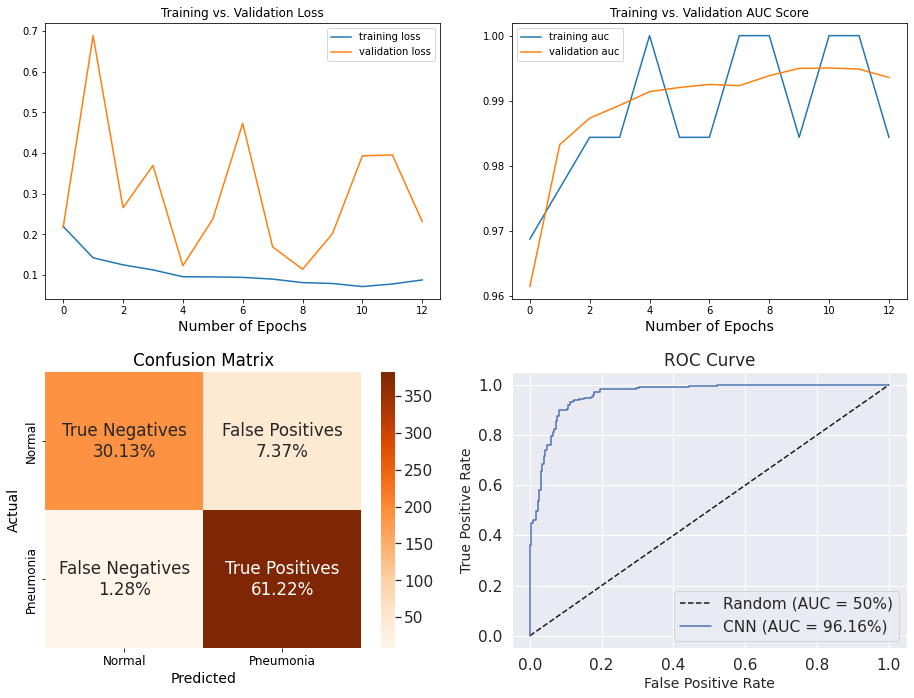

In [ ]:
create_charts(model, vgg19_model)